# Implementing Flat Tax Rate
We will be looking at what individuals actually pay in income tax, and what they are expected to pay (before returns and credtis). We will then being using this data to generate the best flat tax rate system. The flat tax rate system will remove all returns and credits from income tax and be a flat rate on your income, but our goals is to ensure that no-one pays more than they are currently paying (expecially low income families). Because of the complications in 2020 and the COVID-19 virus the US goverment provided many tax credits to assist with the burden of the market changes. This in-turn means the tax revenue varies slightly so we will be using 2019 tax records to create an ideal flat tax system, instead of the outlier low revenue of 2020. \
Evan Sellers + Michael Yager

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("./data/tax_data_2019.csv")
df = df[df.zipcode != 0]

In [3]:
def toMillion(amount):
    return round(amount / 1000000, 2)

def toBillion(amount):
    return round(amount / 1000000000, 2)

def toTrillion(amount):
    return round(amount / 1000000000000, 10)

In [4]:
def sumColumns(dataframe, columns):
    total = 0
    for col in columns:
        total += abs(dataframe[col].sum())
    return total

In [5]:
def sumRows(row, columns):
    total = 0
    for col in columns:
        total += abs(row[col])
    return total

## Flat Tax Rate Basic (w/o Credits & Returns)
According to the report by congres the revenue made from income tax in 2019 was `$1,718 Billion`. So what flat tax rate can we set to ensure we reach this number? This practice is a massive over simplification, which we will explore later. \
[Revenues in Fiscal Year 2019](https://www.cbo.gov/system/files/2020-11/56746-MBR.pdf)

In [6]:
1718/toBillion(df["A02650"].sum()*1000)

0.1410956181515653

This means citizens would have to pay only `~15%` of their annual income for taxes. Why is this number so low, the progressive tax system brackets start at `10%` and go upto `30%`, so why is this number so low? This is because this doesn't account for returns and credits. Additionally, this doesn't reflect that `15%` is much more than many low-income families pay at the momement. So how much do actually pay in tax and would this more or less than people actually pay now?

## Income Tax Actual vs Expected
The actual income tax is how much individual paid in income tax after credits and returns. While the expected is how much the individual would of paid before returns and credits. These values will be put in relation to the total income of the individual. This estimates the "tax bracket" or overall percentage of their income they pay in income tax. This is not reflective of the tax bracket a group of individuals are in because the US tax bracket is progressive.

In [7]:
# Remove Rows w/ Zero Income - prevents divide by zero errors
df = df[df["A02650"] != 0]

### Actual

In [8]:
df["actPctPaid"] = df.apply(lambda row: row["A06500"] / row["A00100"], axis=1)

In [9]:
actPctPaid = df.groupby(["agi_stub"])["actPctPaid"].mean()
actPctPaid

agi_stub
1    0.012476
2    0.044632
3    0.065787
4    0.078476
5    0.110182
6    0.186672
Name: actPctPaid, dtype: float64

### Expected

In [10]:
TAX_CREDITS = [ "A07230", "A07240", "A07180", "A07300", "A07260", "A09400", "A11560", "A07225", "A11070", "A10960" ]

In [11]:
df["taxPctReturns"] = df.apply(lambda row: 1 - (row["A00100"] / row["A02650"]), axis=1)
df["taxPctCredits"] = df.apply(lambda row: (sumRows(row, TAX_CREDITS) / row["A00100"]), axis=1)
df["expPctPaid"]    = df.apply(lambda row: row["taxPctReturns"] + row["taxPctCredits"] + row["actPctPaid"], axis=1)

In [12]:
expPctPaid = df.groupby(["agi_stub"])["expPctPaid"].mean()
expPctPaid

agi_stub
1    0.072357
2    0.089968
3    0.100669
4    0.106225
5    0.134201
6    0.202190
Name: expPctPaid, dtype: float64

### Delta Between Actual & Expected

In [13]:
dltPctPaid = actPctPaid - expPctPaid
dltPctPaid

agi_stub
1   -0.059882
2   -0.045336
3   -0.034882
4   -0.027749
5   -0.024018
6   -0.015518
dtype: float64

This result is surprising. Most people feel that the wealthy are not paying there fair share. But this shows that it's actually the lower-class that are not paying their "fair share" according to the US's Progressive tax bracket. But that is not as much of a consern beacuase this is relative to yearly income, so lower income families not paying their "fair share" is a wash, what this actually means is lower-income families are taking advange of tax returns and credits.

## Flat Tax Rate Basic (w/ Credits & Returns)
If we keep tax credits and returns so individuals can take advantage of those, what would the flat tax rate have to be?

In [14]:
# Note we are using "Adjust gross income" here instead of "income"
1718/toBillion((df["A00100"].sum() - sumColumns(df, TAX_CREDITS))*1000)

0.14536445610594176

This means citizens would have to pay only `~15%` of their annual income for taxes. So this is very similar to if credits and returns were not included. But this is much more than many families are pay now or even how much they are expected pay. How can we account for this? We account for this by adding a minimum taxable amount. Meaning the first X amount is not taxed.

## Flat Tax Rate Advanced
To simplifly this tax system we will not be including the possible of credits & returns, as they do not impact the overall results. We be looking for a percentage and a minable taxable amount that has everyone (expecailly low-income families as changes in tax rate impact them the most) similar rate to what they are currently actually paying. We will be doing this by searching a range of values and scoring each result.

### System Setup

In [15]:
# note: minTaxable is a factor of 1000
def simTaxSystem(dataframe, minTaxable, rate):
    brackets    = dataframe.groupby("agi_stub")
    income      = brackets["A02650"].sum()
    individuals = brackets["N1"].sum()
    oldTax      = (brackets["A06500"].sum() / income)
    newTaxed    = (income - (individuals * minTaxable)) * rate
    newTaxed[newTaxed < 0] = 0
    newTax      = newTaxed / income
    dltTax      = newTax - oldTax
    return oldTax.round(3), newTax.round(3), dltTax.round(3), toBillion(newTaxed.sum()*1000)

In [16]:
def scoreTaxSystem(dltTax, revenue, goalRevenue):
    if revenue < goalRevenue:
        return None
    return dltTax.copy().abs().sum()

In [17]:
def searchTaxSystem(dataframe, goalRevenue):
    columns = ["Tax Rate", "Taxable Min", "Revenue", "Score", "OTR1", "OTR2", "OTR3", "OTR4", "OTR5", "OTR6", "NTR1", "NTR2", "NTR3", "NTR4", "NTR5", "NTR6", "DTR1", "DTR2", "DTR3", "DTR4", "DTR5", "DTR6" ]
    grid    = pd.DataFrame(columns=columns)
    total   = len(TAX_RATE) * len(MIN_TAXABLE)
    done    = 0

    for rate in TAX_RATE:
        for minTax in MIN_TAXABLE:
            oldTax, newTax, dltTax, revenue = simTaxSystem(dataframe, minTax, rate)
            score = scoreTaxSystem(dltTax, revenue, goalRevenue)
            row = [rate, minTax, revenue, score] + oldTax.values.tolist() + newTax.values.tolist() + dltTax.values.tolist()
            grid = pd.concat([grid, pd.DataFrame([row], columns=columns)], ignore_index=True)
            done += 1
            print('\r' + str(done) + " of " + str(total), end="\r")
            
    return grid

In [18]:
MIN_TAXABLE = list(range(0, 100, 5))                                 # $0 - $100,000 by 5000s
TAX_RATE    = list(map(lambda x: round(x * 0.01, 2), range(1, 31))) # 0.01% - 0.30% by 0.01

### Perform Search

In [19]:
grid = searchTaxSystem(df, 1718)

In [20]:
grid

,Tax Rate,Taxable Min,Revenue,Score,OTR1,OTR2,OTR3,OTR4,OTR5,OTR6,...,NTR3,NTR4,NTR5,NTR6,DTR1,DTR2,DTR3,DTR4,DTR5,DTR6
0,0.01,0,121.76,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.010,0.010,0.010,0.010,-0.003,-0.034,-0.059,-0.073,-0.101,-0.196
1,0.01,5,114.03,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.009,0.009,0.010,0.010,-0.007,-0.036,-0.059,-0.073,-0.101,-0.196
2,0.01,10,106.30,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.008,0.009,0.009,0.010,-0.011,-0.037,-0.060,-0.074,-0.102,-0.196
3,0.01,15,99.71,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.008,0.008,0.009,0.010,-0.013,-0.038,-0.061,-0.075,-0.102,-0.197
4,0.01,20,94.48,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.007,0.008,0.009,0.010,-0.013,-0.040,-0.062,-0.075,-0.103,-0.197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.30,75,1625.84,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.000,0.043,0.137,0.256,-0.013,-0.044,-0.069,-0.040,0.026,0.050
596,0.30,80,1558.45,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.000,0.026,0.127,0.253,-0.013,-0.044,-0.069,-0.057,0.015,0.047
597,0.30,85,1491.06,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.000,0.009,0.116,0.250,-0.013,-0.044,-0.069,-0.074,0.005,0.044
598,0.30,90,1434.21,NaN,0.013,0.044,0.069,0.083,0.111,0.206,...,0.000,0.000,0.105,0.247,-0.013,-0.044,-0.069,-0.083,-0.006,0.041


/tmp/ipykernel_677568/509815075.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  sns.heatmap(grid.pivot(index="Tax Rate", columns="Taxable Min", values="Score"))


<AxesSubplot: xlabel='Taxable Min', ylabel='Tax Rate'>

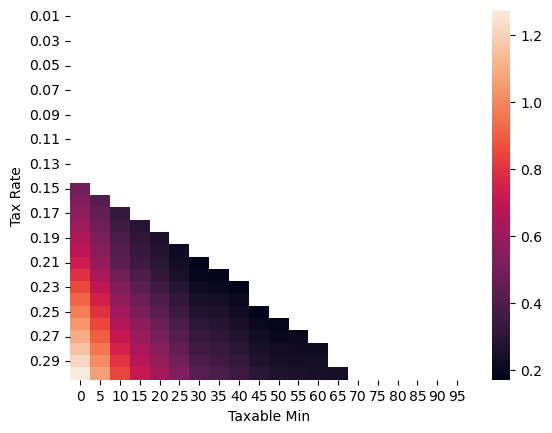

In [21]:
grid["Score"] = grid["Score"].astype(float)
sns.heatmap(grid.pivot(index="Tax Rate", columns="Taxable Min", values="Score"))

In [22]:
grid.iloc[grid["Score"].idxmin()]

Tax Rate          0.23
Taxable Min         40
Revenue        1720.22
Score             0.17
OTR1             0.013
OTR2             0.044
OTR3             0.069
OTR4             0.083
OTR5             0.111
OTR6             0.206
NTR1               0.0
NTR2               0.0
NTR3             0.082
NTR4             0.125
NTR5             0.163
NTR6             0.212
DTR1            -0.013
DTR2            -0.044
DTR3             0.013
DTR4             0.042
DTR5             0.052
DTR6             0.006
Name: 448, dtype: object

This means the best tax system we found is at a `23%` flat tax rate, with the first `$45k` not being taxed. This flat tax has the least affect on the change in cost of income taxes.

## Verify Income Tax System (2020)
According to the congress report we have to account for `$1,609 Billion` in revenue for income taxes. \
[Revenues in Fiscal Year 2020](https://www.cbo.gov/system/files/2020-11/56746-MBR.pdf)

In [23]:
df = pd.read_csv("./data/tax_data_2020.csv")
df = df[df.zipcode != 0]

In [24]:
columns = ["Tax Rate", "Taxable Min", "Revenue", "Score", "OTR1", "OTR2", "OTR3", "OTR4", "OTR5", "OTR6", "NTR1", "NTR2", "NTR3", "NTR4", "NTR5", "NTR6", "DTR1", "DTR2", "DTR3", "DTR4", "DTR5", "DTR6" ]
oldTax, newTax, dltTax, revenue = simTaxSystem(df, 45, 0.23)
score = scoreTaxSystem(dltTax, revenue, 1609)
row = [0.23, 45, revenue, score] + oldTax.values.tolist() + newTax.values.tolist() + dltTax.values.tolist()
results = pd.DataFrame([row], columns=columns).iloc[0]

In [25]:
results

Tax Rate          0.230
Taxable Min      45.000
Revenue        1762.030
Score             0.135
OTR1              0.013
OTR2              0.044
OTR3              0.068
OTR4              0.083
OTR5              0.111
OTR6              0.211
NTR1              0.000
NTR2              0.000
NTR3              0.063
NTR4              0.112
NTR5              0.155
NTR6              0.211
DTR1             -0.013
DTR2             -0.044
DTR3             -0.005
DTR4              0.029
DTR5              0.044
DTR6              0.000
Name: 0, dtype: float64

We have validated the results with 2020's data and it still works out.

## Conclusion


We have determined that the best flat tax system to minimize the change on peoples taxes would to be a `23%` flat tax with the first `$45K` not being taxed. This system would be implemented with not credits or returns.